In [1]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats

dtheta_inc = 0.018

# PadeOps data, momentum thicknesses, normalized (divide by du)
dtheta = { # without
    #0.2: 0.5798895658492144, #512x724x256
    0.2: 0.788860490594119, #1024x1448x512
    0.4: 0.5722299202352464, #1024x1448x512
    #0.4: 0.49852783929915573, #256x512x128
    0.7: 0.5142073604032211, # 724x1024x362 
    0.8: 0.4749713945432585, #512x724x256
    #0.8: 0.3115052326411899, #1024x1024x512
    #1.2: 0.28619993695608875, #724x724x256
    1.2: 0.4893231182668889, #1024x1448x512
    1.6: 0.3185768557761245, #1024x1448x512, 0.31857685577612443
    2.0: 0.24678799366444854 #1024x1448x512, 0.25409518195736686
}
dtheta_LAD = { # with LAD terms on
    #0.2: 2.4772274188368604, #def wrong...
    0.2: 0.9027169573546875, # scaled wrong
    0.4: 0.8897455412186945,
    0.7: 0.535240772247,
    0.8: 0.46023505727307684,
    1.2: 0.20638482817685463
}


Text(0,0.5,'Normalized growth rate $\\dot{\\delta}/\\dot{\\delta_{inc}}$')

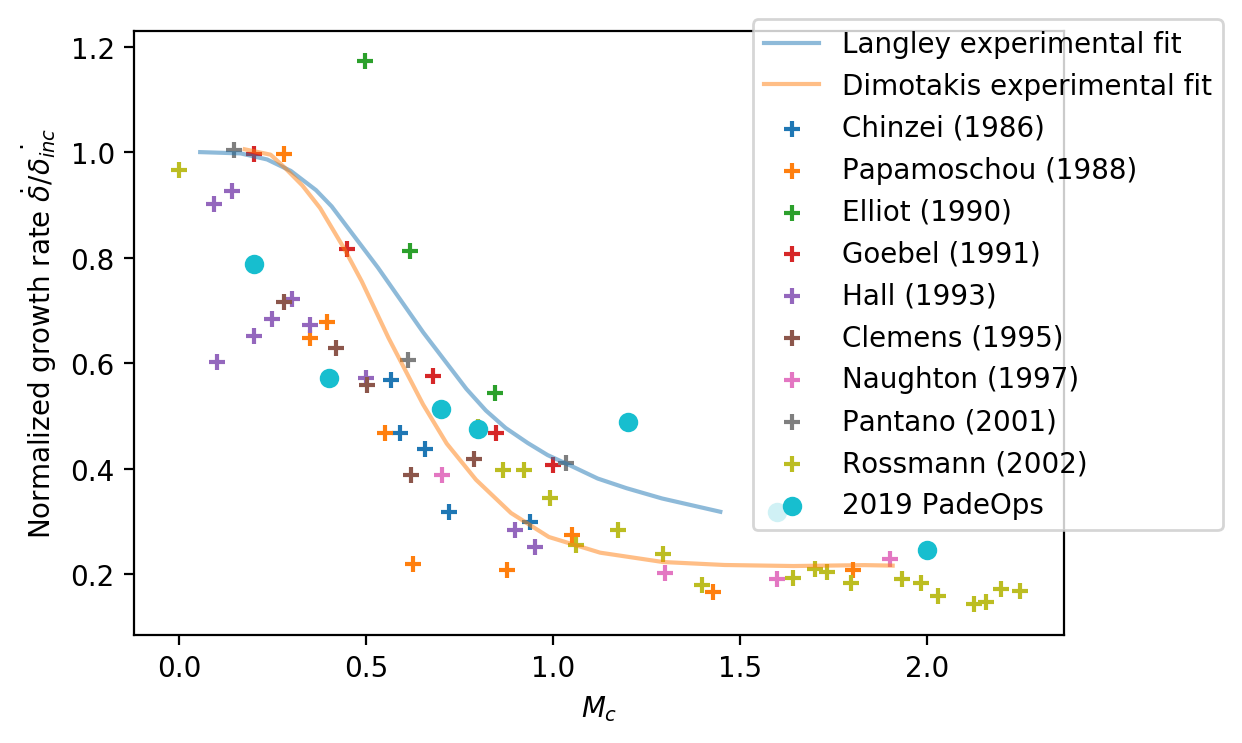

In [2]:
# Literature comparison
def read_data(fname):
    dat = np.fromfile('/home/kmatsuno/FloATPy/post/lit/'+fname,dtype=float, count=-1, sep=' ')
    dat = np.array(dat)
    n = np.size(dat)/2
    dat = np.reshape(dat,[n,2])
    return dat[:,0],dat[:,1]

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
            
plt.figure(figsize=(6,4),dpi=100)

            
# Experimental fit
Mc,growth=read_data('fits/Langley')
plt.plot(Mc,growth,alpha=0.5,label='Langley experimental fit')
Mc,growth=read_data('fits/Dimotakis')
plt.plot(Mc,growth,alpha=0.5,label='Dimotakis experimental fit')

# data files
files = [f for f in get_files('/home/kmatsuno/FloATPy/post/lit/')]
years = [f[-4::] for f in files]
file_dict = {}
for i in range(len(files)):
    auth,year = files[i].split('_')
    file_dict[year] = auth

# Plot, sorted by year
for year in sorted(years):
    auth = file_dict[year]
    Mc,growth = read_data(auth+'_'+year)
    plt.scatter(Mc,growth,marker='+',label=auth + ' ('+year+')')

# PadeOps data:
# plt.scatter(dtheta_LAD.keys(),dtheta_LAD.values(),marker='s',label='2019 PadeOps (LAD)')
plt.scatter(dtheta.keys(),dtheta.values(),marker='o',label='2019 PadeOps')
# plt.scatter(dtheta_LAD.keys(),dtheta_LAD.values(),c='k',label='Current DNS')
plt.legend(bbox_to_anchor=(0.65, 0.15))
plt.xlabel('$M_c$')
plt.ylabel('Normalized growth rate $\dot{\delta}/\dot{\delta_{inc}}$')
